## Data import, preprocessing and exploration

Data will be imported from the orf_genomic.fasta file using SeqIO interface from Bio library. Data contains all yeast genes IDs, their sequences and at which chromosomes they are localised. I aim to create a dataframe containing: gene ID, gene length, chromosom and content of each bases.

In [190]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

In [191]:
# defyining function which allows changing the bar width.
# solution by jsgounot (https://stackoverflow.com/users/5016055/jsgounot)
def set_bar_width(ax, new_width):
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(new_width)
        diff = current_width - new_width
        patch.set_x(patch.get_x() + diff * .5)

In [192]:
# importing data from the orf_genomic.fasta file
# data are asigned to list, which will serve as a base for creating dataframe

all_genes_data = SeqIO.parse("orf_genomic.fasta", "fasta")

# preparing list for storing extracted data
gene_ID = []
chromosome = []
gene_length = []
base_content = [[],[],[],[],[]]

bases = ['A', 'T', 'C', 'G']

# a loop extracting desired data
# some of the genes did not have an assigned chromosome, which resulted in error. a try/except is applied to avoid that
for seq_record in all_genes_data:
    gene_ID.append(seq_record.id)
    try:
        chromosome.append(seq_record.description.split('Chr ')[1].split(' ')[0]) # extracting chromosome number
    except IndexError:
        chromosome.append('no data') # no data is assigned to genes with no assigned chromosome       
    gene_length.append(len(seq_record))
    for index, base in enumerate(bases):
        base_content[index].append(round((seq_record.seq).count(base) / len(seq_record)*100, 5))

In [193]:
# creating dataframe

all_genes_df = pd.DataFrame()
all_genes_df['gene_ID'] = gene_ID
all_genes_df['chromosome'] = chromosome
all_genes_df['gene_length[bp]'] = gene_length
for index, base in enumerate(bases):
    all_genes_df[base+'_content[%]'] = base_content[index]
all_genes_df.head()

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%]
0,YAL001C,I,3573,35.32046,27.59586,15.81304,21.27064
1,YAL002W,I,3825,31.89542,30.92810,18.74510,18.43137
2,YAL003W,I,987,29.68592,31.10436,18.84498,20.36474
3,YAL005C,I,1929,29.13427,26.80145,21.15086,22.91343
4,YAL007C,I,648,30.86420,32.09877,17.59259,19.44444


The all_genes_df dataframe contains gene ID, gene lenght and % content of each nucleotyde. Let's check if nucleotyde content sums up to 100% for every gene

In [194]:
all_genes_df['total_check'] = all_genes_df.loc[:, 'A_content[%]' : 'G_content[%]'].sum(axis=1)
all_genes_df.groupby('total_check')['gene_ID'].count()

total_check
99.99999       17
99.99999      741
99.99999      159
100.00000     231
100.00000    3568
100.00000     210
100.00001       1
100.00001     165
100.00001     814
100.00001      11
Name: gene_ID, dtype: int64

All values are very cloe to 100%, the differences are at 0.01 level which is probably a result of round() function used when importing data.

In [195]:
all_genes_df.drop('total_check', axis=1, inplace=True) # removing 'total_check column'

Now let's some quick charts to see how gene lenghts nad bases contents are distributed in yeast genes and if there are any correlation between gene lengths and bases contents.

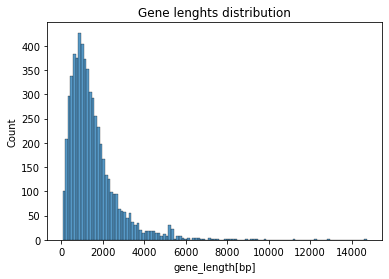

In [196]:
sns.histplot(all_genes_df['gene_length[bp]'])
plt.title('Gene lenghts distribution')
plt.show()

Gene lenghts ranges up to approx. 15000 base pairs, however only few of them are longer than 5000. Most of them have lenght of around 1000-1500 base pairs.

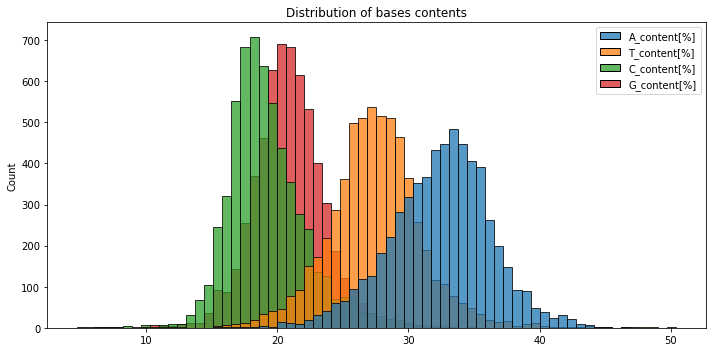

In [197]:
data = all_genes_df.loc[:, 'A_content[%]' : 'G_content[%]']
fig, ax = plt.subplots()
fig.set_size_inches([10, 5])
sns.histplot(data)
plt.title('Distribution of bases contents')
plt.tight_layout()
plt.show()

The charts shows that adenine content is the highest in yeast genes (mostly between 25% and 40%). The lowest is guanine (mostly 15%-25%)

For geneticists, an interesting parameter is content of GC pairs. GC pairs have three hydrogen bonds, while AT two, so physical properties of DNA encoding genes are different depending on GC content - the more GC pairs, the more energy is required for separation of DNA strands. Let's see if there is some correlation between GC content and gene lenght. I calculate average GC content and label genes as these which are above and below average GC content.

In [198]:
all_genes_df['GC_content[%]'] = all_genes_df.loc[:, 'C_content[%]' : 'G_content[%]'].sum(axis=1)
all_genes_df

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%]
0,YAL001C,I,3573,35.32046,27.59586,15.81304,21.27064,37.08368
1,YAL002W,I,3825,31.89542,30.92810,18.74510,18.43137,37.17647
2,YAL003W,I,987,29.68592,31.10436,18.84498,20.36474,39.20972
3,YAL005C,I,1929,29.13427,26.80145,21.15086,22.91343,44.06429
4,YAL007C,I,648,30.86420,32.09877,17.59259,19.44444,37.03703
...,...,...,...,...,...,...,...,...
5912,Q0275,Mito,810,30.12346,39.87654,13.82716,16.17284,30.00000
5913,R0010W,no data,1272,35.69182,27.27987,17.61006,19.41824,37.02830
5914,R0020C,no data,1122,33.33333,26.82709,16.75579,23.08378,39.83957
5915,R0030W,no data,546,29.67033,30.40293,20.87912,19.04762,39.92674


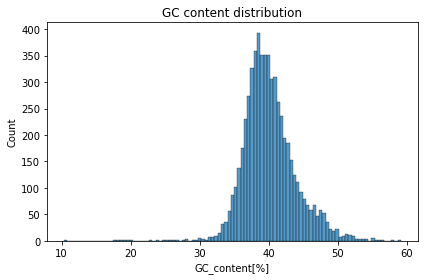

In [199]:
sns.histplot(all_genes_df['GC_content[%]'])
plt.title('GC content distribution')
plt.tight_layout()
plt.show()

GC content for most of the genes ranges from 30 to 50%, significantly peaking around 40%. The distribution is slightly skewed to the higher values

It would be interesting to see if GC content is somehow correlated with gene length. To visualise that, a scatter plot showing relations between GC content and gene lenght will be suitable. Medians for both values are indicated

In [200]:
# defining medians for GC content and gene length
GC_median = all_genes_df['GC_content[%]'].median()
lenght_median = all_genes_df['gene_length[bp]'].median()

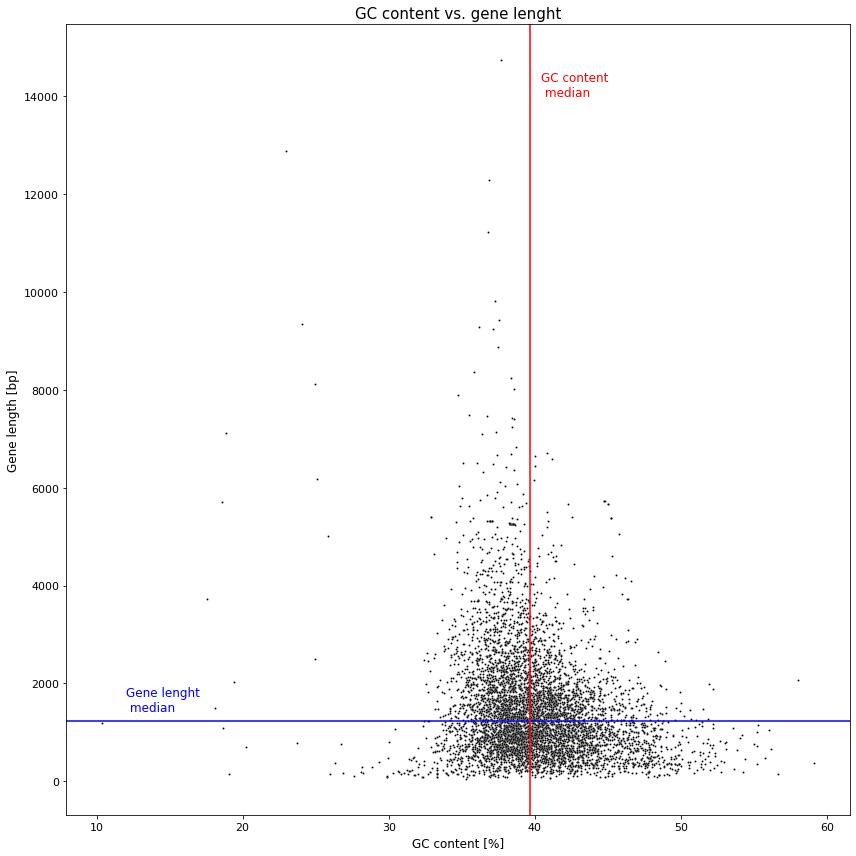

In [201]:
fig, ax = plt.subplots()
fig.set_size_inches([12,12])

ax = sns.scatterplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', s=4, color='black')

ax.set_title('GC content vs. gene lenght', fontsize=15)
ax.set_xlabel('GC content [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
ax.set_ylabel('Gene length [bp]', fontsize=12)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


ax.axhline(lenght_median, c='b')
ax.text(12, lenght_median + 200, 'Gene lenght \n median', c='b', fontsize=12)
ax.axvline(GC_median, c='r')
ax.text(GC_median + 0.75, 14000, 'GC content \n median', c='r', fontsize=12)
plt.tight_layout()
plt.show()

While there is no clear corelation between GC content and gene length and most of the genes localize around the intersection point of both medians, an interesting phenomenon is visiible - longer genes (above 2000 bp) tend to have GC content lower than the median. The longer a gene is, the more is likely that its content is below the median. There are not genes longer than 7000 bp with GC content above the median. Reverse tendency is observed for short genes - genes below gene lenght median tend to have higher GC content. Perhapse, it will be possible to create a ML model predicting GC content based on gene lenth (or vice versa), however the lack of obvious correlation implies that this kind of a model will rather not be very accurate.

Interestingly, there are a few genes with low GC content which significantly stand out from the "main body". It would be interesting to find out see if they are just occasional outliers or maybe there is a feature which unites them. Let's check if these outliers are located on a particular chromosome

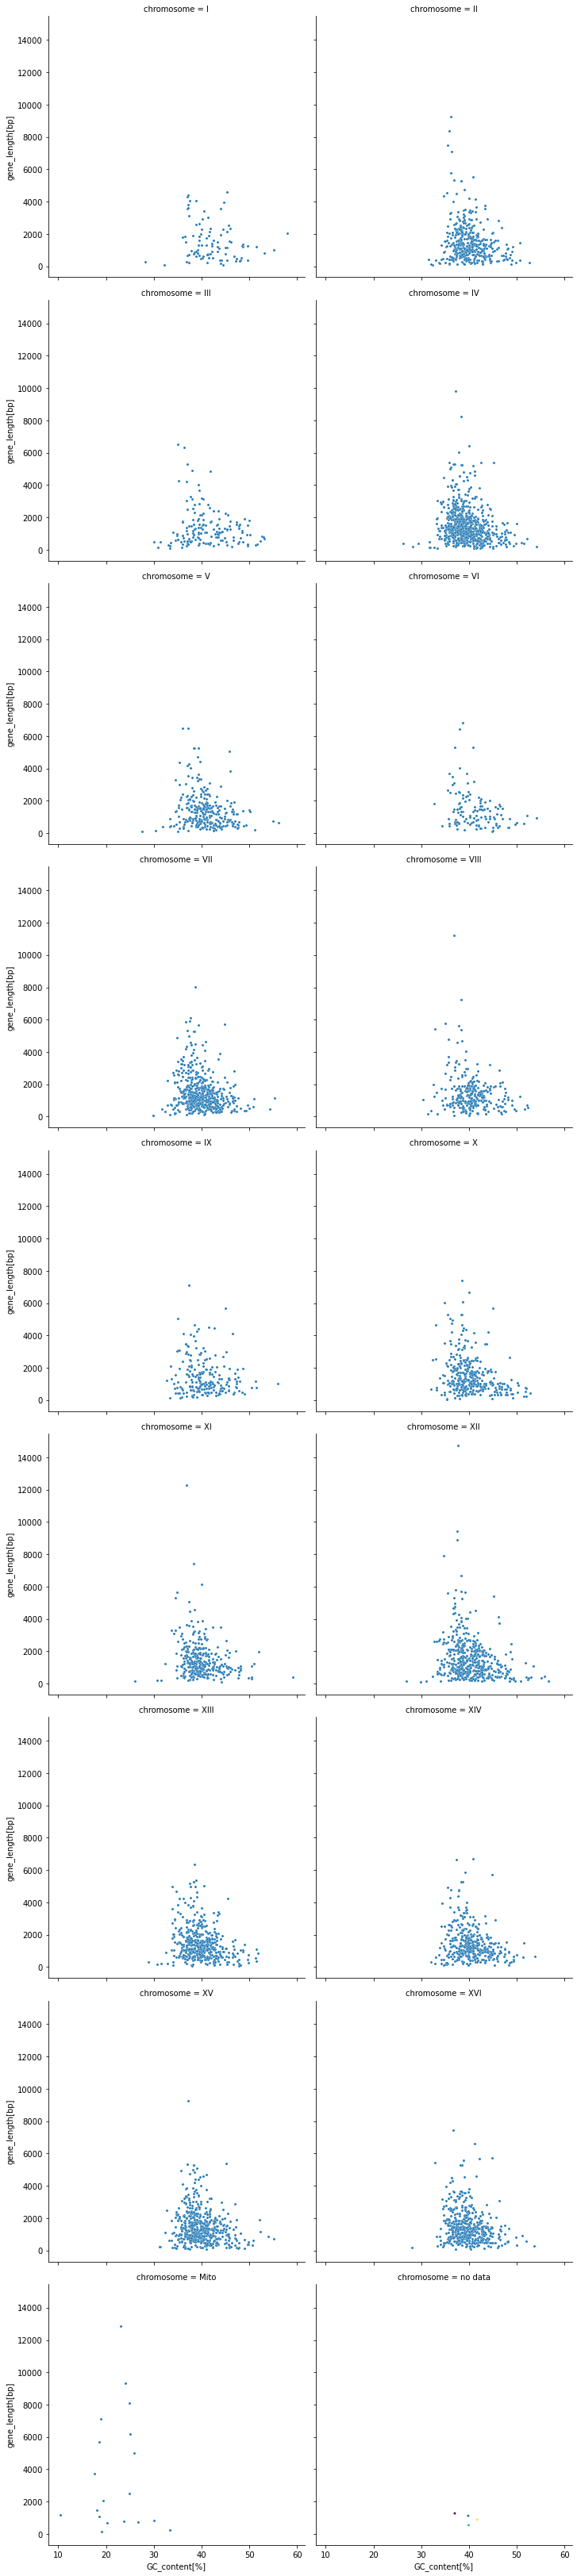

In [202]:
sns.relplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', col='chromosome', col_wrap=2, s=10)
plt.show()

Bingo! Most of the outliers are located on the mitochondrial chromosome. Despite it is probably an elegant indicator of endosymbiotic mitochondrial origin, these genes will likely disturb performance of ML models. Let's focus on nuclear genom and remove mitochondrially encoded genes, same as genes with unasigned chromosomes, from our dataset.

The relation between GC content and gene length is similar on the nuclear chromosomes, except the chromosome I, which has a distinct pattern, which points at higher GC content in genes located on this chromosome. However, number of genes on the chromosome I is quite low, therefore it's more likely to observe higher deviations.

In [203]:
# removing mitochondrial and not assigned to chromosome genes

print('number of rows before dropping:', len(all_genes_df))
all_genes_df.drop(all_genes_df[all_genes_df['chromosome'].isin(['Mito', 'no data'])].index, inplace=True)
print('number of rows after dropping:', len(all_genes_df))

number of rows before dropping: 5917
number of rows after dropping: 5894


Just one more check if we have only nuclear chromosomes

In [204]:
all_genes_df['chromosome'].unique()

array(['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XV', 'XVI'], dtype=object)

Looks fine.

Now, let's assign genes to categories telling, if there are below or above each of the medians. This will allow to visialise data using barplot counting how many genes are in each category. This will further tell if our prediction based on the previous scatter plot were true.

In [205]:
# setting conditions for categories: below/above GC content/gene length medians)

condition1 = (all_genes_df['GC_content[%]'] <= GC_median) & (all_genes_df['gene_length[bp]'] <= lenght_median)
condition2 = (all_genes_df['GC_content[%]'] > GC_median) & (all_genes_df['gene_length[bp]'] <= lenght_median)
condition3 = (all_genes_df['GC_content[%]'] <= GC_median) & (all_genes_df['gene_length[bp]'] > lenght_median)
condition4 = (all_genes_df['GC_content[%]'] > GC_median) & (all_genes_df['gene_length[bp]'] > lenght_median)

# adding a category column to the all_genes_df using np.select function
condition_list = [condition1, condition2, condition3, condition4]
choice_list = ['GC content below \n length below', 'GC content above \n length below', 'GC content below \n lenght above', 'GC content above \n lenght above']
all_genes_df['category'] = np.select(condition_list, choice_list, default=0)

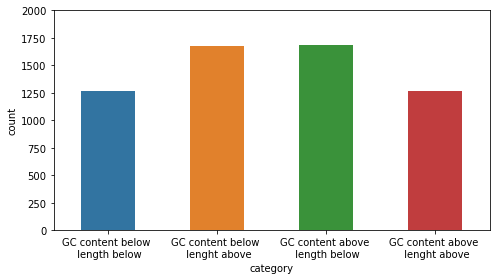

In [206]:
# creating a countplot
order = all_genes_df['category'].value_counts().sort_index(ascending=False).index
fig, ax = plt.subplots()
fig.set_size_inches([7, 4])
ax = sns.countplot(x= all_genes_df['category'], order=order)
set_bar_width(ax, 0.5)
ax.set_ylim(0,2000)


plt.tight_layout()
plt.show()

In [207]:
# counting the share of each category
all_genes_df['category'].value_counts().sort_index(ascending=False)

GC content below \n length below    1264
GC content below \n lenght above    1676
GC content above \n length below    1689
GC content above \n lenght above    1265
Name: category, dtype: int64

The count plot shows confirm our previous observations - when a gene lenght is below the median, more genes have GC content above the median, and when a gene length is above the median, more genes have GC content below the median.

To check if observed results are statistically significant, I perform a chi-squared test.

In [208]:
counted = all_genes_df['category'].value_counts()
stat.chisquare(counted)

Power_divergenceResult(statistic=118.63522225992534, pvalue=1.5182778190145012e-25)

Just to check if the chi-square test from the scipy.stats performes well, I perform calculations manually using excel. Always good to repeat maths behind the test

In [209]:
chisquare_excel = pd.read_excel('chisquare.xlsx')
chisquare_excel

,category,observed,expected,diff,diff^2,diff^2 / expected,chi_square statistic
0,GC content below \n length below,1264,1473.5,-209.5,43890.25,29.786393,118.078724
1,GC content below \n lenght above,1675,1473.5,201.5,40602.25,27.554971,NaN
2,GC content above \n length below,1689,1473.5,215.5,46440.25,31.516966,NaN
3,GC content above \n lenght above,1266,1473.5,-207.5,43056.25,29.220394,NaN
4,NaN,5894,NaN,NaN,NaN,NaN,NaN


In both cases chi-square statistic is the same, meaning that the test from the stats package performs well and I remember it from my studies.

P-value is extremely low (2 * 10^-25). This means that assigning to categories are not idependent. In other words, observed differences between categories are not caused by a coincidence, and there is another reason behind these result. One can tell that longer genes tend to have lower GC content, and shorter genes tend to have higher GC content.

To work further on all_genes_df, I'm going to save it as a CSV file. 

In [211]:
all_genes_df.to_csv('all_genes_df.csv')